In [1]:
import numpy as np
import pandas as pd
import jax
import plotly.graph_objects as go
import jax.numpy as jnp
from jax import random
from functools import partial
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import pandas as pd
import plotly.graph_objects as go

# matplotlib.rcParams['figure.dpi'] = 600

print(jax.default_backend())

key = random.PRNGKey(42)
new_key, subkey = random.split(key)

cpu


In [2]:
def compute_price_relatives(df):
    
    df = df.copy(deep=True)

    for stock in list(df.columns)[1:]:
        df[stock] = df[stock] / df[stock].shift(+1)

    df = df.iloc[1:, :]

    return df

In [3]:
# Load Stock Data

df_stocks = pd.read_csv("../data/stock_prices_8.csv")
df_stocks["Cash"] = 1
df_stocks_relatives = compute_price_relatives(df_stocks)

In [4]:
def make_fictional_data(N=1000):
    
    #     s1 = 100 + 100*np.random.lognormal(size=(N, ), sigma=1)
    #     s2 = 200 + 50*np.random.lognormal(size=(N, ), sigma=1)
    #     s_all = jnp.vstack((s1, s2))
    
    s_all = np.exp(np.random.multivariate_normal([0., 0.],
                                                 cov = np.array([[0.3, 0.05], [0.05, 0.3]]), size=N).T)
    
    # Convert x_all to stock multipliers

    x_all = s_all[:, 1:] / s_all[:, 0:-1]
    x_all = jnp.hstack((jnp.array([1., 1.])[:, None], x_all))
    
    return x_all

In [5]:
# Pick which x_all to use

x_all = df_stocks_relatives[["AAPL", "AMZN"]].T.to_numpy()
# x_all = make_fictional_data(N=100)

In [6]:
@jax.jit
def S_k(b, x_k):
    """
    Wealth upto time k
    b = some scalar, where we set b2 = 1 - b1, shape = (2, )
    x_k = matrix of stock multiples, shape = (2, K)
    """
    b_full = jnp.array([b, 1. - b])
    return jnp.multiply(b_full[..., None], x_k).sum(axis=0).prod()

In [7]:
def get_hindsight_optimal_portfolio(x_all):

    # Hindsight optimal portfolio

    b_hos = list(np.arange(0, 1, 0.01))
    W_ho = jax.tree_map(S_k, b_hos, [x_all for _ in range(len(b_hos))])
    combined_mat = np.vstack([b_hos, W_ho])
    b_ho = combined_mat[0, np.argmax(combined_mat[1, :])]
    
    # Plot to check
    
    plt.figure(figsize=(7, 3))
    plt.plot(np.array(b_hos), W_ho, "ro-")
    plt.xlabel("Fraction in Stock 1")
    plt.ylabel("Wealth Multiplier")
    
    return b_ho

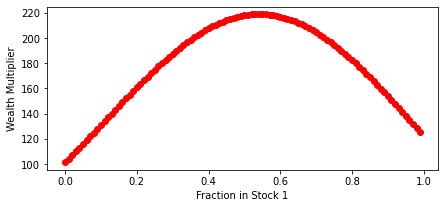

In [8]:
b_ho = get_hindsight_optimal_portfolio(x_all)

In [9]:
# Check extreme portfolios lineup

# assert S_k(1, x_all) == x_all.prod(axis=1)[0]
# assert S_k(0, x_all) == x_all.prod(axis=1)[1]

# New Approach

In [10]:
def S_n(b_mat, x_mat):
    # If passing a fixed b_mat, make sure to do b_mat[..., None]
    return ((b_mat) * (x_mat)).sum(axis=0).cumprod()

In [ ]:
# Integration of b_k_next

@jax.jit
def num_body_fun(i, x):
    return (i/100)*S_k(i/100, x)

@jax.jit
def denom_body_fun(i, x):
    return S_k(i/100, x)

def b_k_next(x_k):    
    
    # Numerator
    
    i_idx = list(jnp.arange(0, 101, 1))
    x_rep = [x_k for i in range(0, len(i_idx))]
    num_list = jax.tree_map(num_body_fun, i_idx, x_rep)
    num = jnp.trapz(jnp.array(num_list))
    
    # Denominator
    
    denom_list = jax.tree_map(denom_body_fun, i_idx, x_rep)
    denom = jnp.trapz(jnp.array(denom_list))
    
    return num/denom

# Transform x's into a list of smaller arrays (memory consuming!)

xs = [x_all[:, 0:i] for i in tqdm(range(1, x_all.shape[1]))]

# Loop over time and calculate universal portfolio

b_univ = [0.5]

for i in tqdm(range(len(xs))):
    b_univ.append(b_k_next(xs[i]))

# TODO: can this be parallelized easily? should be able to.

 60%|█████▉    | 3002/5030 [05:23<03:50,  8.81it/s]

In [ ]:
b_univ = jnp.array(b_univ)
b_univ_all = jnp.vstack((jnp.array(b_univ), 1-jnp.array(b_univ)))
print(b_univ_all.shape)

In [ ]:
W_b_univ = S_n(b_univ_all, x_all)
W_b_ho_opt = S_n(jnp.array([b_ho, 1-b_ho])[..., None], x_all)
W_b_s0 = S_n(jnp.array([1., 0])[..., None], x_all)
W_b_s1 = S_n(jnp.array([0., 1.])[..., None], x_all)

In [ ]:
t = [i for i in range(0, len(W_b_univ))]

In [ ]:
def plot_wealth_multiplier(df_wealth_multiplier, stocks,
                           title_text="Wealth Multiplier", yaxis_text="Multiplier"):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df_wealth_multiplier["Date"],
                             y=df_wealth_multiplier["universal_portfolio"],
                             mode='lines',
                             name="Universal Portfolio",
                             marker=dict(color='Black')))

    fig.add_trace(go.Scatter(x=df_wealth_multiplier["Date"],
                             y=df_wealth_multiplier["stock_1_only"],
                             mode='lines',
                             name=stocks[0],
                             marker=dict(color='Red')))

    fig.add_trace(go.Scatter(x=df_wealth_multiplier["Date"],
                             y=df_wealth_multiplier["stock_2_only"],
                             mode='lines',
                             name=stocks[1],
                             marker=dict(color='Blue')))

    fig.update_layout(title=title_text, yaxis_title=yaxis_text)

    return fig

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=t,
                         y=W_b_ho_opt,
                         mode='lines',
                         name="Hindsight Optimal (Fixed & Rebalanced)",
                         marker=dict(color='Green')))

fig.add_trace(go.Scatter(x=t,
                         y=W_b_univ,
                         mode='lines',
                         name="Universal Portfolio",
                         marker=dict(color='Black')))

fig.add_trace(go.Scatter(x=t,
                         y=W_b_s0,
                         mode='lines',
                         name="Stock 1",
                         marker=dict(color='Red')))

fig.add_trace(go.Scatter(x=t,
                         y=W_b_s1,
                         mode='lines',
                         name="Stock 2",
                         marker=dict(color='Blue')))

# fig.update_layout(title=title_text, yaxis_title=yaxis_text)

In [ ]:
# plt.figure(figsize=(17, 7))
# plt.plot(W_b_univ, "r", label="Universal Portfolio")
# plt.plot(W_b_ho_opt, "g", label="Hindsight Optimal (Fixed & Rebalanced)")
# plt.plot(W_b_s0, color="blue", label="Investing in Stock 1 only")
# plt.plot(W_b_s1, color="darkblue", label="Investing in Stock 0 only")
# plt.xlabel("Time (Discretized into 1 day)")
# plt.ylabel("Wealth Factor")
# plt.legend()